# Markov Chain Monte Carlo (MCMC)

## Why Sampling ?

Lets start with why we need sampling. Sampling data from a distribution helps use make sense of the parameters defined in that space. Maybe provide a numerical value to some of them with a probability. 

Lets take an example of defining $\pi$ using sampling from a uniform distrbution. We will generate around 5000 samples from a uniform distribution and then match is against the area of of the circle equation. If we start from $(0,0)$, samples are considered positive if within the circle. So the equation becomes,
$$
f(x,y) = \mathbb{I}(x^2 + y^2 \leq r^2)
$$


In [2]:
import torch

# pi_n_samples = 5000
# radius = torch.tensor([2.0])
# uniform_distribution = torch.distributions.Uniform(low=radius.negative(),high=radius)
# samples_x_y = uniform_distribution.sample(sample_shape=(pi_n_samples,2))
# samples_within_circle_area = torch.where(samples_x_y.square().sum(dim=1)<=radius.square(),
#                                          torch.tensor(True), torch.tensor(False))
# # area formed by valid samples is the area of the circle (total_area = 4r^2)
# extracted_valid_samples = 4 * radius.square() * samples_within_circle_area 
# estimated_pi = extracted_valid_samples.mean()/radius.square()
# print('Estimated pi : ',estimated_pi.item())
# print('Actual pi :', torch.pi)


## MCMC



In [3]:
from typing import Callable, NamedTuple
import torch.jit as jit  
import arviz as az

from sklearn.datasets import load_iris

# theta
class Position(NamedTuple):
    weights: torch.Tensor
    bias: torch.Tensor

class EnergyParameters:
    #potential
    position: Position
    potential_energy: torch.Tensor
    potential_energy_grad: torch.Tensor
    #kinetic
    velocity: torch.Tensor
    kinetic_energy: torch.Tensor

    def __init__(self, potential_energy_fn:Callable, n_variables:int):
        self.potential_energy_fn = potential_energy_fn
        self.n_varaibles = n_variables
    
    def set_parameters(self, position:Position):
        self.position = position
        self.potential_energy = self.potential_energy_fn(position)
        self.potential_energy_grad = torch.func.grad(self.potential_energy_fn)(position)
        self.velocity, self.precision, self.covariance = self.generate_default_velocity(position)
        self.kinetic_energy = self.kinetic_energy_fn(self.velocity)
    
    def set_velocity(self, velocity:torch.Tensor):
        self.velocity = velocity
        self.kinetic_energy = self.kinetic_energy_fn(self.velocity)
    
    def generate_default_velocity(self, position:Position):
        precision, covariance = self.generate_inverse_mass_matrix_and_sigma(self.n_varaibles)
        return self.generate_random_gaussian(covariance), precision, covariance

    def generate_random_gaussian(self, covariance: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=torch.zeros(covariance.shape[-1]),covariance_matrix=covariance).sample()

    def generate_inverse_mass_matrix_and_sigma(self, covariance_shape: int):
        covariance = torch.eye(covariance_shape)
        inverse_mass_matrix = covariance.inverse()
        return inverse_mass_matrix, covariance

    def kinetic_energy_fn(self, velocity:torch.Tensor):
        return 0.5*torch.matmul(velocity, torch.matmul(self.precision, velocity.T))

class HMCAlgorithm : 

    def __init__(self, log_density_fn: Callable, step_size=0.01, l=1, n_chains=4, n_variables=2,use_kinetic_grad=False):
        self.log_density_fn = log_density_fn
        self.step_size = step_size
        self.l = l
        self.n_variables = n_variables
        self.energy_parameters = EnergyParameters(log_density_fn, n_variables)
        self.proposal_accepted_count = [0]*n_chains
        self.use_kinetic_grad = use_kinetic_grad

    def updated_position(self, position:Position, step_size:float, inverse_mass_matrix:torch.Tensor, velocity:torch.Tensor):
        # print(position)
        weights = position['weights']
        # torch.matmul(inverse_mass_matrix,velocity) is the kinetic gradient
        if self.use_kinetic_grad:
            result = weights + step_size*torch.func.grad(self.energy_parameters.kinetic_energy_fn)(velocity)
        else:
            result = weights + step_size*torch.matmul(inverse_mass_matrix,velocity)
        return result

    def updated_velocity(self, velocity:torch.Tensor, step_size:float, next_potential_energy_grad:torch.Tensor, is_half_step_momentum = False):
        return torch.subtract(velocity,step_size*(0.5 if is_half_step_momentum else 1)*next_potential_energy_grad)
    
    def update(self, position: Position, chain_index:int, iteration_no:int):
        delta_energy, proposal_position = self.step_integrator(position)
        # nan fix
        delta_energy = torch.where(torch.isnan(delta_energy), -torch.inf, delta_energy)
        # MH Algo
        alpha = torch.min(torch.exp(delta_energy), torch.ones(1))
        # print(f'Delta energy : {delta_energy}, {total_prev_energy}, {total_proposal_energy}, {alpha}')
        accept_condition = torch.distributions.Bernoulli(alpha).sample()
        print(f'Delta energy : {delta_energy}, {alpha}, {proposal_position.a}, {proposal_position.b}, {self.proposal_accepted_count[chain_index]}')
        result_proposal = position
        if accept_condition.bool():
            self.proposal_accepted_count[chain_index] += 1
            result_proposal = proposal_position
    
        acceptance_ratio = self.proposal_accepted_count[chain_index]/iteration_no
        return result_proposal, acceptance_ratio
  
    def step_integrator(self, position:Position):
        self.energy_parameters.set_parameters(position)
        print('------------HERE-----------')
        prev_potential_energy = self.energy_parameters.potential_energy
        prev_kinetic_energy = self.energy_parameters.kinetic_energy
        prev_velocity = self.energy_parameters.velocity
        prev_potential_energy_grad = self.energy_parameters.potential_energy_grad

        prev_half_velocity = torch.subtract(prev_velocity,
                                             self.step_size*0.5*prev_potential_energy_grad)
        # print('prev_half_velocity',prev_half_velocity)
        self.energy_parameters.set_velocity(prev_half_velocity)

        # l_frog_steps
        next_position, next_velocity = self.l_frog_steps(prev_half_velocity, position, self.energy_parameters.precision)
        
        full_step_position = self.updated_position(position=next_position, step_size=self.step_size,
                                                   inverse_mass_matrix=self.energy_parameters.precision, velocity=next_velocity)
        # print('full_step_position',full_step_position)
        self.energy_parameters.set_parameters(full_step_position)
        half_step_potential_energy_grad = self.energy_parameters.potential_energy_grad
        # print('half_step_potential_energy_grad',half_step_potential_energy_grad)

        half_step_velocity = self.updated_velocity(velocity=next_velocity,step_size=self.step_size,
                                                   next_potential_energy_grad=half_step_potential_energy_grad,is_half_step_momentum=True)
        # print('half_step_velocity',half_step_velocity)
        self.energy_parameters.set_velocity(half_step_velocity)

        total_proposal_energy = -self.energy_parameters.potential_energy - self.energy_parameters.kinetic_energy
        total_prev_energy = -prev_potential_energy - prev_kinetic_energy
        return total_prev_energy - total_proposal_energy, full_step_position

    def l_frog_steps(self, prev_half_velocity, prev_position, precision):
        for _ in range(self.l):
            # print(prev_position)
            next_position = self.updated_position(position=prev_position, step_size=self.step_size,
                                                  inverse_mass_matrix=precision, velocity=prev_half_velocity)
            # print('next_position',next_position)

            self.energy_parameters.set_parameters(next_position)
            next_potential_energy_grad = self.energy_parameters.potential_energy_grad
            # print('next_potential_energy_grad',next_potential_energy_grad)

            next_velocity = self.updated_velocity(prev_half_velocity, step_size=self.step_size, next_potential_energy_grad=next_potential_energy_grad)
            # print('next_velocity',next_velocity)
            self.energy_parameters.set_velocity(next_velocity)
            prev_half_velocity = next_velocity
            prev_position = next_position
        return next_position,next_velocity
    

In [4]:
iris = load_iris()
data = torch.tensor(iris.data[:100], dtype=torch.float32).T
X = torch.stack([data[0], data[1]]).T
y = torch.tensor(iris.target[:100], dtype=torch.float32)

X = X[25:75]
y = y[25:75]
bias_prior = torch.distributions.normal.Normal(loc=torch.tensor([0.0]), scale=torch.tensor([20.0]))
weights_prior = torch.distributions.normal.Normal(loc=torch.tensor([0.0]), scale=torch.tensor([2.0]))

def joint_logprob_fn(params, inputs=X, outputs=y):
    weights = params['weights']
    bias = params['bias']
    # prior logprob
    log_prior = weights_prior.log_prob(weights).sum() + bias_prior.log_prob(bias)
    # likelihood logprob
    matmul_term = torch.matmul(inputs, weights).squeeze()
    logits = torch.add(matmul_term, bias)
    log_lik = torch.vmap(lambda logit,val : torch.distributions.bernoulli.Bernoulli(logits=logit, validate_args=False).log_prob(val))(logits, outputs).sum()

    return (log_lik + log_prior).squeeze()

# initialize the params for two chains
# n_chains = 2
# variables = X.shape[-1]
# initial_params = {
#     'weights': weights_prior.sample(sample_shape=(variables,)),
#     'bias' : bias_prior.sample(),
# }

# print(initial_params, joint_logprob_fn(initial_params))
# print(torch.func.grad(joint_logprob_fn)(initial_params))

In [5]:
def scan(func, init_values, length):
    carry = init_values
    result = []
    for i in range(length):
        carry = func(carry,i)
        result.append(carry)
    return carry, result 

def same_state_multiple_chains(hmc: HMCAlgorithm, n_variables=2, n_chains=4, n_samples = 10, burn_in_time = 5):
    def delta_step(positions:list[Position],iteration_no:int):
        current_state = []
        for i,position in enumerate(positions):
            position_after_update, _ = hmc.update(position, i, iteration_no)
            current_state.append(position_after_update)
        print('-----------------------------')
        return current_state
    
    init_states: list[Position] = []
    for _ in range(n_chains):
        init_states.append({'weights': weights_prior.sample(sample_shape=(n_variables,)),'bias' : bias_prior.sample()})
    
    final_state, result = scan(delta_step, init_values=init_states, length=n_samples)
    output = {}
    return (final_state, output)

n_variables = X.shape[-1]
n_chains = 2
n_samples = 1500
burn_in_time = 500
hmc = HMCAlgorithm(log_density_fn=joint_logprob_fn, n_chains=n_chains, use_kinetic_grad=True)
final_state, position_per_sample = same_state_multiple_chains(hmc, n_variables,  n_chains, n_samples, burn_in_time)

------------HERE-----------


/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_60933/3279435791.py:49: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  return 0.5*torch.matmul(velocity, torch.matmul(self.precision, velocity.T))


TypeError: unsupported operand type(s) for *: 'float' and 'dict'

In [13]:
trace = az.convert_to_inference_data(position_per_sample)
summary = az.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,6.116,11.881,-15.644,18.539,5.851,4.471,5.0,11.0,2.75
b,2.551,19.173,-14.044,43.690,9.427,7.202,5.0,12.0,2.76
thetas[0],-0.360,1.512,-2.577,2.502,0.737,0.562,4.0,11.0,3.50
thetas[1],3.567,2.733,0.031,8.692,1.335,1.019,4.0,11.0,3.90
thetas[2],2.136,3.978,-3.322,9.193,1.960,1.498,4.0,11.0,4.39
...,...,...,...,...,...,...,...,...,...
thetas[66],-1.029,6.646,-7.048,12.303,3.283,2.510,5.0,12.0,2.85
thetas[67],0.375,5.443,-7.092,8.273,2.690,2.057,4.0,11.0,3.33
thetas[68],6.565,3.073,1.504,11.902,1.470,1.118,4.0,11.0,3.16
thetas[69],1.608,3.120,-4.213,5.695,1.532,1.170,4.0,11.0,3.75


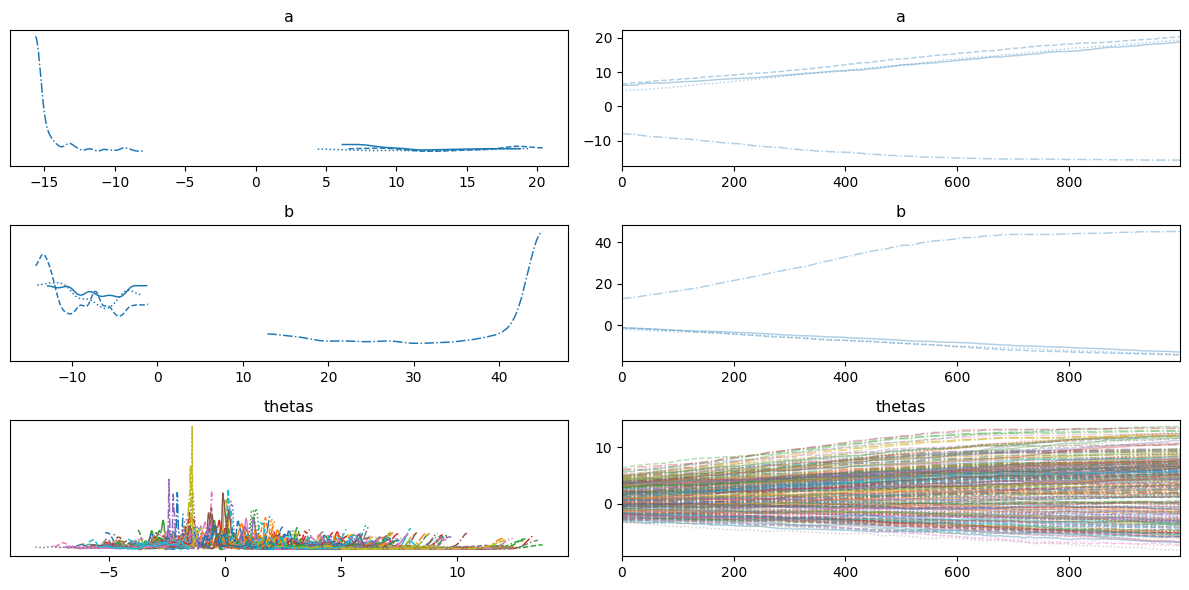

In [14]:
import matplotlib.pyplot as plt

az.plot_trace(trace)
plt.tight_layout()